# Emulate XKCD Plots in Matplotlib


## Matplotlib Version
http://matplotlib.org/xkcd/examples/showcase/xkcd.html

NameError: name 'fm' is not defined

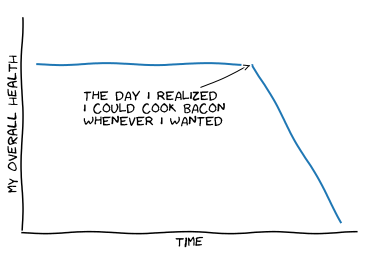

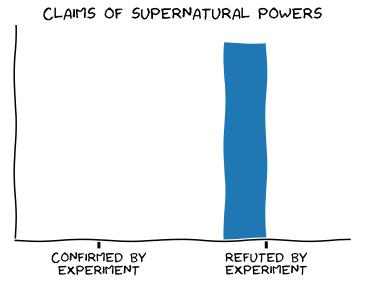

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import os

from urllib.request import urlopen
if not os.path.exists('Humor-Sans.ttf'):
    fhandle = urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

plt.xkcd()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
ax.set_ylim([-30, 10])

data = np.ones(100)
data[70:] -= np.arange(30)

plt.annotate(
    'THE DAY I REALIZED\nI COULD COOK BACON\nWHENEVER I WANTED',
    xy=(70, 1), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))

plt.plot(data)

plt.xlabel('time')
plt.ylabel('my overall health')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar([-0.125, 1.0-0.125], [0, 100], 0.25)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 110])
ax.set_xticklabels(['CONFIRMED BY\nEXPERIMENT', 'REFUTED BY\nEXPERIMENT'])
plt.yticks([])

plt.title("CLAIMS OF SUPERNATURAL POWERS")

# Change all the fonts to humor-sans.
prop = fm.FontProperties(fname='Humor-Sans-1.0.ttf', size=16)
for text in ax.texts:
    text.set_fontproperties(prop)

plt.show()

## Custom Version XKCDfy

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

"""
XKCD plot generator
-------------------
Author: Jake Vanderplas

This is a script that will take any matplotlib line diagram, and convert it
to an XKCD-style plot.  It will work for plots with line & text elements,
including axes labels and titles (but not axes tick labels).

The idea for this comes from work by Damon McDougall
  http://www.mail-archive.com/matplotlib-users@lists.sourceforge.net/msg25499.html
"""
import numpy as np
import pylab as pl
from scipy import interpolate, signal
import matplotlib.font_manager as fm


# We need a special font for the code below.  It can be downloaded this way:
import os
#import urllib2
from urllib.request import urlopen
if not os.path.exists('Humor-Sans-1.0.ttf'):
    fhandle = urlopen('http://antiyawn.com/uploads/Humor-Sans-1.0.ttf')
    open('Humor-Sans.ttf', 'wb').write(fhandle.read())

    
def xkcd_line(x, y, xlim=None, ylim=None,
              mag=1.0, f1=30, f2=0.05, f3=15):
    """
    Mimic a hand-drawn line from (x, y) data

    Parameters
    ----------
    x, y : array_like
        arrays to be modified
    xlim, ylim : data range
        the assumed plot range for the modification.  If not specified,
        they will be guessed from the  data
    mag : float
        magnitude of distortions
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    
    Returns
    -------
    x, y : ndarrays
        The modified lines
    """
    x = np.asarray(x)
    y = np.asarray(y)
    
    # get limits for rescaling
    if xlim is None:
        xlim = (x.min(), x.max())
    if ylim is None:
        ylim = (y.min(), y.max())

    if xlim[1] == xlim[0]:
        xlim = ylim
        
    if ylim[1] == ylim[0]:
        ylim = xlim

    # scale the data
    x_scaled = (x - xlim[0]) * 1. / (xlim[1] - xlim[0])
    y_scaled = (y - ylim[0]) * 1. / (ylim[1] - ylim[0])

    # compute the total distance along the path
    dx = x_scaled[1:] - x_scaled[:-1]
    dy = y_scaled[1:] - y_scaled[:-1]
    dist_tot = np.sum(np.sqrt(dx * dx + dy * dy))

    # number of interpolated points is proportional to the distance
    Nu = int(200 * dist_tot)
    u = np.arange(-1, Nu + 1) * 1. / (Nu - 1)

    # interpolate curve at sampled points
    k = min(3, len(x) - 1)
    res = interpolate.splprep([x_scaled, y_scaled], s=0, k=k)
    x_int, y_int = interpolate.splev(u, res[0]) 

    # we'll perturb perpendicular to the drawn line
    dx = x_int[2:] - x_int[:-2]
    dy = y_int[2:] - y_int[:-2]
    dist = np.sqrt(dx * dx + dy * dy)

    # create a filtered perturbation
    coeffs = mag * np.random.normal(0, 0.01, len(x_int) - 2)
    b = signal.firwin(f1, f2 * dist_tot, window=('kaiser', f3))
    response = signal.lfilter(b, 1, coeffs)

    x_int[1:-1] += response * dy / dist
    y_int[1:-1] += response * dx / dist

    # un-scale data
    x_int = x_int[1:-1] * (xlim[1] - xlim[0]) + xlim[0]
    y_int = y_int[1:-1] * (ylim[1] - ylim[0]) + ylim[0]
    
    return x_int, y_int


def XKCDify(ax, mag=1.0,
            f1=50, f2=0.01, f3=15,
            bgcolor='w',
            xaxis_loc=None,
            yaxis_loc=None,
            xaxis_arrow='+',
            yaxis_arrow='+',
            ax_extend=0.1,
            expand_axes=False):
    """Make axis look hand-drawn

    This adjusts all lines, text, legends, and axes in the figure to look
    like xkcd plots.  Other plot elements are not modified.
    
    Parameters
    ----------
    ax : Axes instance
        the axes to be modified.
    mag : float
        the magnitude of the distortion
    f1, f2, f3 : int, float, int
        filtering parameters.  f1 gives the size of the window, f2 gives
        the high-frequency cutoff, f3 gives the size of the filter
    xaxis_loc, yaxis_log : float
        The locations to draw the x and y axes.  If not specified, they
        will be drawn from the bottom left of the plot
    xaxis_arrow, yaxis_arrow : str
        where to draw arrows on the x/y axes.  Options are '+', '-', '+-', or ''
    ax_extend : float
        How far (fractionally) to extend the drawn axes beyond the original
        axes limits
    expand_axes : bool
        if True, then expand axes to fill the figure (useful if there is only
        a single axes in the figure)
    """
    # Get axes aspect
    ext = ax.get_window_extent().extents
    aspect = (ext[3] - ext[1]) / (ext[2] - ext[0])

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - xlim[0]

    xax_lim = (xlim[0] - ax_extend * xspan,
               xlim[1] + ax_extend * xspan)
    yax_lim = (ylim[0] - ax_extend * yspan,
               ylim[1] + ax_extend * yspan)

    if xaxis_loc is None:
        xaxis_loc = ylim[0]

    if yaxis_loc is None:
        yaxis_loc = xlim[0]

    # Draw axes
    xaxis = pl.Line2D([xax_lim[0], xax_lim[1]], [xaxis_loc, xaxis_loc],
                      linestyle='-', color='k')
    yaxis = pl.Line2D([yaxis_loc, yaxis_loc], [yax_lim[0], yax_lim[1]],
                      linestyle='-', color='k')

    # Label axes3, 0.5, 'hello', fontsize=14)
    ax.text(xax_lim[1], xaxis_loc - 0.02 * yspan, ax.get_xlabel(),
            fontsize=14, ha='right', va='top', rotation=12)
    ax.text(yaxis_loc - 0.02 * xspan, yax_lim[1], ax.get_ylabel(),
            fontsize=14, ha='right', va='top', rotation=78)
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add title
    ax.text(0.5 * (xax_lim[1] + xax_lim[0]), yax_lim[1],
            ax.get_title(),
            ha='center', va='bottom', fontsize=16)
    ax.set_title('')

    Nlines = len(ax.lines)
    lines = [xaxis, yaxis] + [ax.lines.pop(0) for i in range(Nlines)]

    for line in lines:
        x, y = line.get_data()

        x_int, y_int = xkcd_line(x, y, xlim, ylim,
                                 mag, f1, f2, f3)

        # create foreground and background line
        lw = line.get_linewidth()
        line.set_linewidth(2 * lw)
        line.set_data(x_int, y_int)

        # don't add background line for axes
        if (line is not xaxis) and (line is not yaxis):
            line_bg = pl.Line2D(x_int, y_int, color=bgcolor,
                                linewidth=8 * lw)

            ax.add_line(line_bg)
        ax.add_line(line)

    # Draw arrow-heads at the end of axes lines
    arr1 = 0.03 * np.array([-1, 0, -1])
    arr2 = 0.02 * np.array([-1, 0, 1])

    arr1[::2] += np.random.normal(0, 0.005, 2)
    arr2[::2] += np.random.normal(0, 0.005, 2)

    x, y = xaxis.get_data()
    if '+' in str(xaxis_arrow):
        ax.plot(x[-1] + arr1 * xspan * aspect,
                y[-1] + arr2 * yspan,
                color='k', lw=2)
    if '-' in str(xaxis_arrow):
        ax.plot(x[0] - arr1 * xspan * aspect,
                y[0] - arr2 * yspan,
                color='k', lw=2)

    x, y = yaxis.get_data()
    if '+' in str(yaxis_arrow):
        ax.plot(x[-1] + arr2 * xspan * aspect,
                y[-1] + arr1 * yspan,
                color='k', lw=2)
    if '-' in str(yaxis_arrow):
        ax.plot(x[0] - arr2 * xspan * aspect,
                y[0] - arr1 * yspan,
                color='k', lw=2)

    # Change all the fonts to humor-sans.
    prop = fm.FontProperties(fname='Humor-Sans.ttf', size=16)
    for text in ax.texts:
        text.set_fontproperties(prop)
    
    # modify legend
    leg = ax.get_legend()
    if leg is not None:
        leg.set_frame_on(False)
        
        for child in leg.get_children():
            if isinstance(child, pl.Line2D):
                x, y = child.get_data()
                child.set_data(xkcd_line(x, y, mag=10, f1=100, f2=0.001))
                child.set_linewidth(2 * child.get_linewidth())
            if isinstance(child, pl.Text):
                child.set_fontproperties(prop)
    
    # Set the axis limits
    ax.set_xlim(xax_lim[0] - 0.1 * xspan,
                xax_lim[1] + 0.1 * xspan)
    ax.set_ylim(yax_lim[0] - 0.1 * yspan,
                yax_lim[1] + 0.1 * yspan)

    # adjust the axes
    ax.set_xticks([])
    ax.set_yticks([])      

    if expand_axes:
        ax.figure.set_facecolor(bgcolor)
        ax.set_axis_off()
        ax.set_position([0, 0, 1, 1])
    
    return ax

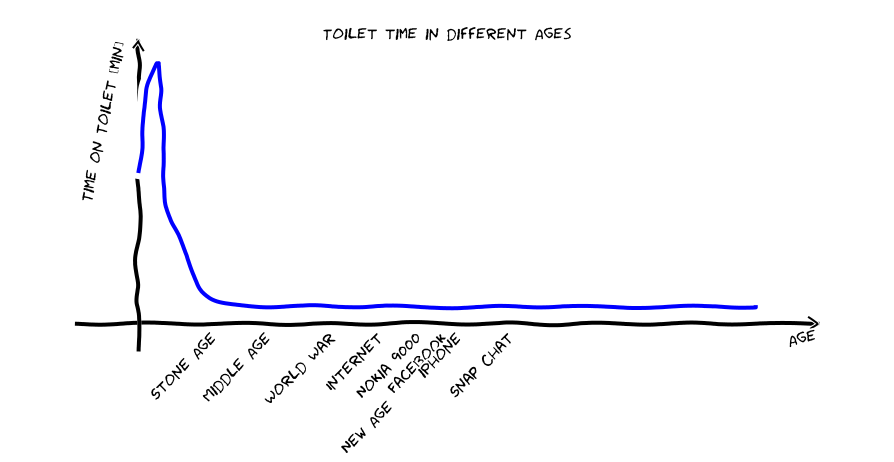

In [5]:
# Some helper functions
def norm(x, x0, sigma):
    return np.exp(-0.5 * (x - x0) ** 2 / sigma ** 2)

def sigmoid(x, x0, alpha):
    return 1. / (1. + np.exp(- (x - x0) / alpha))
    
# define the curves
x = np.linspace(0, 20, 10000)
y1 = np.sin(x) + 0.1

y1 = np.sqrt(norm(x, 0.8, 0.5))  * (1.5 - sigmoid(x, 0.8, 0.05)) + 0.1

#y2 = 0.2 * norm(x, 0.5, 0.2) + np.sqrt(norm(x, 0.6, 0.05)) + 0.1 * (1 - sigmoid(x, 0.75, 0.05))

#y3 = 0.05 + 1.4 * norm(x, 0.85, 0.08)
#y3[x > 0.85] = 0.05 + 1.4 * norm(x[x > 0.85], 0.85, 0.3)

# figure set size 
pl.figure(figsize=(12,5))

# draw the curves
ax = pl.axes()

ax.plot(x, y1, c='blue')

#ax.text(0.05, 1.1, "fear that\nthere's\nsomething\nbehind me")
#ax.plot([0.15, 0.2], [1.0, 0.2], '-k', lw=0.5)

#ax.text(0.25, 0.8, "")
#ax.plot([0.32, 0.35], [0.75, 0.35], '-k', lw=0.5)

#ax.text(0.9, 0.4, "Remove suit of armor ")
#ax.plot([1.0, 0.8], [0.55, 1.05], '-k', lw=0.5)

# Y Axis details
ax.text(0.3, -0.1, "Stone Age", rotation=45)
ax.text(2, -0.1, "Middle Age", rotation=45)
ax.text(6.5, -0.5, "New Age", rotation=45)
ax.text(4, -0.1, "World War", rotation=45)
ax.text(6, -0.1, "Internet", rotation=45)
ax.text(7, -0.1, "Nokia 9000", rotation=45)
ax.text(8, -0.1, "Facebook", rotation=45)
ax.text(9, -0.1, "iPhone", rotation=45)
ax.text(10, -0.1, "Snap Chat", rotation=45)

# Title and Axis Texts
ax.set_title('Toilet time in different Ages')
ax.set_xlabel('Age')
ax.set_ylabel('Time on Toilet [min]')

ax.legend(loc='lower right')

# Set Plot size
ax.set_xlim(0, 20)
ax.set_ylim(0, 1.5)

# modify all the axes elements in-place
XKCDify(ax, expand_axes=True)